In [1]:
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
from iit_tpm import make_tpm

In [2]:
w = {
    'w1': 0.7,
    'w2': 0.2,
    'w3': -0.8,
    'w4': -0.2
}

bnet = {
    ('A', 'B'): 'w1',
    ('B', 'A'): 'w1',
    ('A', 'C'): 'w2',
    ('C', 'B'): 'w3',
    ('A', 'A'): 'w4',
    ('B', 'B'): 'w4',
    ('C', 'C'): 'w2'
}

(          cab       Cab       cAb       CAb       caB       CaB       cAB  \
 cab  0.169634  0.034249  0.022957  0.004635  0.563205  0.113709  0.076222   
 Cab  0.437982  0.437982  0.059274  0.059274  0.002416  0.002416  0.000327   
 cAb  0.000541  0.000541  0.000015  0.000015  0.486160  0.486160  0.013284   
 CAb  0.065620  0.325019  0.001793  0.008881  0.097894  0.484871  0.002675   
 caB  0.013248  0.002675  0.484871  0.097894  0.008881  0.001793  0.325019   
 CaB  0.013284  0.013284  0.486160  0.486160  0.000015  0.000015  0.000541   
 cAB  0.000327  0.000327  0.002416  0.002416  0.059274  0.059274  0.437982   
 CAB  0.015389  0.076222  0.113709  0.563205  0.004635  0.022957  0.034249   
 
           CAB  
 cab  0.015389  
 Cab  0.000327  
 cAb  0.013284  
 CAb  0.013248  
 caB  0.065620  
 CaB  0.000541  
 cAB  0.437982  
 CAB  0.169634  ,
 array([[1.69634150e-01, 3.42485442e-02, 2.29574857e-02, 4.63503643e-03,
         5.63205212e-01, 1.13709171e-01, 7.62215369e-02, 1.53888629e-

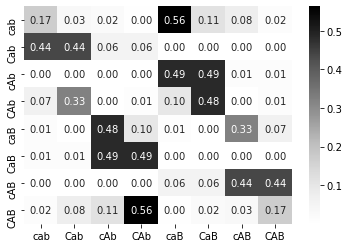

In [3]:
tpm, tpm_v = make_tpm(bnet, w, k=4)
tpm, tpm_v

In [10]:
# get state name of sources

list(tpm.index)

['abc', 'Abc', 'aBc', 'ABc', 'abC', 'AbC', 'aBC', 'ABC']

In [11]:
# get state name of targets

list(tpm.columns) 

['abc', 'Abc', 'aBc', 'ABc', 'abC', 'AbC', 'aBC', 'ABC']